# Virtual ADC example
---


## Load the bitstream into the Programmable Logic

In [27]:
# Import the X-HEEP Python class
from pynq import x_heep
# Load the X-HEEP bitstream
xh = x_heep()

In [28]:
import sys
print(sys.version)
print(sys.path)


3.10.4 (main, Apr  2 2022, 09:04:19) [GCC 11.2.0]
['/home/xilinx', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/share/pynq-venv/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3.10/dist-packages', '/home/xilinx/x-heep-femu-sdk/sw/arm/sdk/']


## Generate a random array to use as input signal 

In [29]:
import numpy as np
# Set the seed for reproducibility (optional)
np.random.seed(46)

# Generate a random integer array
array_size = 32
rand_in = np.random.randint(0, 100, size=array_size, dtype=np.int32)

# Print the generated array
print("Generated Array:", rand_in)

# Save the array to a binary file
file_path = "/home/xilinx/x-heep-femu-sdk/sw/riscv/apps/virtual_adc_read/adc_in.bin"
data = rand_in.copy()
with open(file_path, 'wb') as file:
    data.byteswap(True).tofile(file)

Generated Array: [61 69 40 58 19 18 75 93 60 27 80  2 72 32 31 55 22 98 59 79 30 98  2 22
 87 72 48  2 40 72 76  1]


## Compile the code and run the application
You can change the variable `SKIP_COMPILE` to 1 to avoid compiling each time.

In [30]:
# This will automatically make accessible the changes made in the sdk
%reload_ext autoreload 

# Skip compiling if all you want to do is run the application
SKIP_COMPILE = 0

# Compile the application
if SKIP_COMPILE or xh.compile_app("virtual_adc_read"):
    adc = xh.init_adc_mem() # Init the ADC memory
    xh.reset_adc_mem(adc)   # Reset the ADC memory
    xh.write_adc_mem(adc)   # Write the ADC memory

    t, sf = xh.thread_start()   # Start a background thread that reads from the UART
    out, _ = xh.run_app()       # Run the application (disregarding the error output)
    xh.thread_stop(t, sf)       # Stop the background thread that reads from the UART

✅ Compile SUCCESS
✅ Return SUCCESS
 


### Check if the CPU's output is the same as the expected result

The application is supposed to make the difference of every consecutive pair:

$y[0] = x[0]$

$y[i] = x[i] - x[i-1]$ 

$i \in (0,N]$

In [31]:
app_out = [int(x) for x in xh.uart_data if x.strip()]

exp_out = [rand_in[i] - rand_in[i-1] for i in range(1, len(rand_in))]

if all([a == e for a,e in zip(app_out, exp_out)]): print("✅ SUCCESS")
else: print("❌ FAILED")


✅ SUCCESS


## Plot the input and output

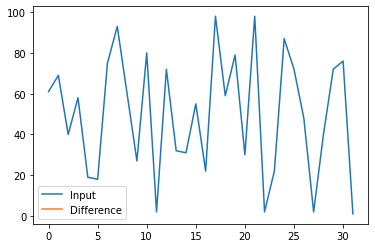

In [32]:
import matplotlib.pyplot as plt

plt.plot(rand_in)
plt.plot(app_out)

plt.legend(["Input", "Difference"])

